# xQTL and GWAS integration: TWAS and MR

This module contains the software implementations to perform transcriptome-wide association analysis (TWAS). These methods are designed to perform rigorous causal inference connecting genes to complex traits.    

## Overview

The goal of this module is to perform PTWAS analysis from SuSiE objects, including:
* **Step 1: PTWAS (twas_z_format)**
1. load GWAS z-score
2. load the corresponding LD matrices within the TAD region of each gene
3. use allele_qc() function to QC the LD matrix with summary stats
4. extract susie, lasso, enet and mr_ash weights
5. use twas_z() to compute TWAS results from multipile weights
* **Step 2: MR (twas_candidate_genes)**
1. use some p-value cutoff to loosely pick TWAS regions of interest then if the region passes the cutoff, save the QC-ed GWAS data in the format compatabile to [mr.R](https://github.com/cumc/pecotmr/blob/main/R/mr.R)


### Input
* **Step 1: TWAS**
1. QTL susie table：
2. GWAS sumstats results (tsv format)    
3. LD reference
4. TAD region
* **Step 2: MR**
1. output of Step 1

### Ouput
* **Step 1: TWAS**
1. TWAS results from multiple weights
2. GWAS summary statistics after QC
3. the input format of twas_z() function
* **Step 2: MR**
1. the candidate genes of TWAS
2. the input format of [mr.R](https://github.com/cumc/pecotmr/blob/main/R/mr.R)
3. the MR results


In [ ]:
[global]
# Workdir
parameter: susie_path = paths
parameter: cwd = path("output")
parameter: container = ''
import re
parameter: entrypoint= ('micromamba run -a "" -n' + ' ' + re.sub(r'(_apptainer:latest|_docker:latest|\.sif)$', '', container.split('/')[-1])) if container else ""
parameter: job_size = 100
parameter: walltime = "1h"
parameter: mem = "16G"
parameter: numThreads = 20

## TWAS 



### Input

- susie_path: A list of file paths for susie results
- GWAS_path: gwas summary statistics path (to load the gwas sumstats dataframe)
- LD_path: LD block matrix path (a list of file paths of LD block)
- TAD_path: TAD region path (a dataframe  of TAD region of each gene, this one is applied to subset the LD matrix for each gene)


### Output

- twas_z_format: a dataframe of input format for the twas_z() function
- gene_weights_pq: a dataframe of output of twas_z() function, we apply twas_z function to the  weights of four methods (susie, lasso, enet and mr_ash) to calculate the pvalue, after obtaining the pvalue, we also calculate the corresponding qvalue
- AD_allele_flip: AD gwas sumstats after QC

In [ ]:
[twas_z_format_1]

import pandas as pd
s_path = pd.read_csv(susie_path, header=None)
# split_path = s_path[0].str.split(".", expand=True)
# ID = pd.DataFrame({'ID': split_path[1]})
# path = pd.DataFrame({'path': s_path[0]})
# input_df = pd.concat([ID, path], axis=1)
input_df = s_path.values.tolist()

parameter: GWAS_path = path
parameter: LD_path = path
parameter: TAD_path = path
#input: susie_path
input: [x for x in input_df], group_by = 1
output: f'{cwd}/{step_name[:-2]}/{_input:bnn}.twas_z.rds'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output:bn}'
R: expand= "${ }", stderr = f'{_output:nn}.stderr', stdout = f'{_output:nn}.stdout'

    options(bedtools.path = "/home/aw3600/bedtools2/bin/")
    library(pecotmr)
    library(dplyr)
    library(stringr)
    library(data.table)

    susie_path = str_split(${_input:ar},"\\.",simplify=T)[,2]%>%cbind(.,${_input:ar})%>%data.frame()%>%setNames(c("ID","path"))
    TAD_region = fread(${TAD_path:ar})%>%rename("ID"="gene_id")
    gene_name = susie_path$ID
    region = TAD_region%>%filter(ID==gene_name)%>%rename("chr"="#chr")
    chr = str_sub(region$chr,4)
    AD_dataset = fread(paste0(${GWAS_path:ar},"/ADGWAS_Bellenguez_2022.",chr,"/ADGWAS2022.chr",chr,".sumstat.tsv",sep=""))
    GWAS_data = AD_dataset%>%mutate(chr = paste0("chr",chromosome))%>%mutate(pos = as.character(position))%>%select(-chromosome)%>%rename("A1"="ref","A2"="alt")%>%mutate(z=beta/se)%>%select(-position)
    LD_list = read.table(${LD_path:ar},header=F,sep="\t")
    LD_block_path = str_split(LD_list$V1,"_",simplify=T)%>%cbind(.,LD_list)%>%rename("chr"="1","start"="2","end"="3","variants"="V1","path" = "V2")
    twas_z = twas_scan(susie_path, region, GWAS_data, LD_block_path)
    saveRDS(twas_z, ${_output:ar}, compress='xz')

In [ ]:
[twas_z_format_2]
# Path to the input molecular phenotype data.
input: group_by = "all"
output: f'{cwd}/{step_name[:-2]}/twas_z_files.txt'
python: expand= "$[ ]", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', container = container, entrypoint = entrypoint
import pandas as pd
pd.DataFrame({"output" : [$[_input:ar,]]}).to_csv("$[_output]",index = False ,header = False, sep = "\t")

## MR

### Input

- weights_path: A list of file paths of the PTWAS output
- pval_threshold: pvalue threshold for selecting the candidate genes, it is default to be 0.05
- cpip_cutoff: cpip cutoff threshold for MR method

### Output

- twas_cand_genes.rds: the candidate significant genes obtained using the multiple weights
- mr_output.rds: the MR results using the candidate genes (cand_genes.rds)

In [ ]:
[twas_candidate_gene]
parameter: weights_path = path
parameter: pval_threshold = 0.05
parameter: cpip_cutoff = 0.5
input: weights_path
output: cand_genes = f'{cwd:a}/{step_name}.rds',
        mr_output = f'{cwd:a}/mr_output.rds'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output:bn}'
R: expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    library(data.table)
    library(dplyr)
    library(stringr)
    library(qvalue)
    library(doMC)
    library(pecotmr)

    ####
    susie_list = fread(${susie_path:ar},header=F)
    susie_path = str_split(susie_list$V1,"\\.",simplify=T)[,2]%>%cbind(.,susie_list)%>%setNames(c("ID","path"))

    #detectCores()
    registerDoMC(100)
    weights_file = fread(${_input:ar},header=F)
    weights_file_path = str_split(weights_file$V1,"\\.",simplify=T)[,2]%>%cbind(.,weights_file)%>%setNames(c("ID","path"))
    #ptm = proc.time()
    gene_pq = foreach(k=1:dim(weights_file)[1], .combine=rbind) %dopar% {
       weights_pq = readRDS(weights_file_path$path[k])$gene_weights_pq
    }
    #proc.time() - ptm
    padj = apply(gene_pq[,c("susie_pval","lasso_pval","enet_pval","mr_ash_pval")],2,function(x) p.adjust(x, method = "bonferroni",))%>%data.frame()
    gene_pq_adj = gene_pq%>%cbind(.,padj)
    names(gene_pq_adj)[15:18] = c("susie_pval_adj","lasso_pval_adj","enet_pval_adj","mr_ash_pval_adj")
    gene.ref = read.table("/mnt/vast/hpc/csg/molecular_phenotype_calling/reference_data/Homo_sapiens.GRCh38.103.chr.reformatted.collapse_only.gene.region_list",header=F)
    gene_pq_adj$gene_id = gene.ref[match(gene_pq_adj$gene_name,gene.ref$V4),"V5"]

    cand_genes = NULL
    cand_genes$gene_pq_adj = gene_pq_adj
    cand_genes$susie= cand_genes$gene_pq_adj%>%filter(susie_pval<${pval_threshold})%>%select(gene_name,gene_id)
    cand_genes$lasso= cand_genes$gene_pq_adj%>%filter(lasso_pval<${pval_threshold})%>%select(gene_name,gene_id)
    cand_genes$enet= cand_genes$gene_pq_adj%>%filter(enet_pval<${pval_threshold})%>%select(gene_name,gene_id)
    cand_genes$mr_ash= cand_genes$gene_pq_adj%>%filter(mr_ash_pval<${pval_threshold})%>%select(gene_name,gene_id)
    cand_genes$susie_adj= cand_genes$gene_pq_adj%>%filter(susie_pval_adj<${pval_threshold})%>%select(gene_name,gene_id)
    cand_genes$lasso_adj= cand_genes$gene_pq_adj%>%filter(lasso_pval_adj<${pval_threshold})%>%select(gene_name,gene_id)
    cand_genes$enet_adj= cand_genes$gene_pq_adj%>%filter(enet_pval_adj<${pval_threshold})%>%select(gene_name,gene_id)
    cand_genes$mr_ash_adj= cand_genes$gene_pq_adj%>%filter(mr_ash_pval_adj<${pval_threshold})%>%select(gene_name,gene_id)

    # cand_genes$susie_format_input = twas_mr_format_input(cand_genes$susie$gene_name,${susie_path:ar},weights_file_path)
    # cand_genes$lasso_format_input = twas_mr_format_input(cand_genes$lasso$gene_name,${susie_path:ar},weights_file_path)
    # cand_genes$enet_format_input = twas_mr_format_input(cand_genes$enet$gene_name,${susie_path:ar},weights_file_path)
    # cand_genes$mr_ash_format_input = twas_mr_format_input(cand_genes$mr_ash$gene_name,${susie_path:ar},weights_file_path)
    cand_genes$susie_adj_format_input = twas_mr_format_input(cand_genes$susie_adj,susie_path,weights_file_path)
    cand_genes$lasso_adj_format_input = twas_mr_format_input(cand_genes$lasso_adj,susie_path,weights_file_path)
    cand_genes$enet_adj_format_input = twas_mr_format_input(cand_genes$enet_adj,susie_path,weights_file_path)
    cand_genes$mr_ash_adj_format_input = twas_mr_format_input(cand_genes$mr_ash_adj,susie_path,weights_file_path)

    saveRDS(cand_genes, ${_output[0]:ar}, compress='xz')

    mr_output = NULL
    # mr_output$susie = fine_mr(cand_genes$susie_format_input,${cpip_cutoff})
    # mr_output$lasso = fine_mr(cand_genes$lasso_format_input,${cpip_cutoff})
    # mr_output$enet = fine_mr(cand_genes$enet_format_input,${cpip_cutoff})
    # mr_output$mr_ash = fine_mr(cand_genes$mr_ash_format_input,${cpip_cutoff})
    if(!is.null(cand_genes$susie_adj_format_input))
    {mr_output$susie_adj = fine_mr(cand_genes$susie_adj_format_input,${cpip_cutoff})}
    if(!is.null(cand_genes$lasso_adj_format_input))
    {mr_output$lasso_adj = fine_mr(cand_genes$lasso_adj_format_input,${cpip_cutoff})}
    if(!is.null(cand_genes$enet_adj_format_input))
    {mr_output$enet_adj = fine_mr(cand_genes$enet_adj_format_input,${cpip_cutoff})}
    if(!is.null(cand_genes$mr_ash_adj_format_input))
    {mr_output$mr_ash_adj = fine_mr(cand_genes$mr_ash_adj_format_input,${cpip_cutoff})}

    saveRDS(mr_output, ${_output[1]:ar}, compress='xz')

### Example
#### Mic pseudo bulk dataset

* fine mapping only on the 612 genes

In [ ]:
sos run ~/xqtl-pipeline/code/cis_analysis/cis_workhorse.ipynb susie \
     --name Mic_pseudo_bulk \
     --genoFile  /mnt/vast/hpc/csg/FunGen_xQTL/ROSMAP/Genotype/geno_by_region/TADB_enhanced_cis_genotype_by_region/ROSMAP_NIA_WGS.leftnorm.bcftools_qc.plink_qc.genotype_by_region_files.txt  \
     --phenoFile  /mnt/vast/hpc/csg/wanggroup/fungen-xqtl-analysis/analysis/Wang_Columbia/ROSMAP/pseudo_bulk_eqtl/Mic/output/data_preprocessing/phenotype_data/Mic.log2cpm.region_list.txt \
     --covFile  /mnt/vast/hpc/csg/wanggroup/fungen-xqtl-analysis/analysis/Wang_Columbia/ROSMAP/pseudo_bulk_eqtl/Mic/output/data_preprocessing/covariate_data/Mic.log2cpm.Mic.rosmap_cov.ROSMAP_NIA_WGS.leftnorm.bcftools_qc.plink_qc.snuc_pseudo_bulk.related.plink_qc.extracted.pca.projected.Marchenko_PC.gz \
     --phenotype_names AD \
     --maf 0.01 \
     --pip_cutoff 0.1 \
     --coverage 0.95 \
     --region-list   ~/MR_KMT_analysis/PTWAS/Mic_AD_phenotype_select.txt \
     --no-indel \
     --cwd ~/MR_KMT_analysis/PTWAS/Mic_pseudo_bulk_SuSiE_results \
     --mem 200G

In [ ]:
sos run ~/xqtl-pipeline/code/pecotmr_integration/ptwas.ipynb twas_z_format \
        --susie_path  ~/MR_KMT_analysis/PTWAS/Mic_pseudo_bulk_SuSiE_results/Mic_pseudo_bulk.cis_workhorse_output.txt \
        --TAD_path ~/fungen-xqtl-analysis/resource/TADB_enhanced_cis.bed \
        --GWAS_path /mnt/vast/hpc/csg/xqtl_workflow_testing/ADGWAS/data_intergration/ADGWAS2022 \
        --LD_path /mnt/vast/hpc/csg/molecular_phenotype_calling/LD/output/1300_hg38_EUR_LD_blocks_LD/ROSMAP_NIA_WGS.leftnorm.filtered.filtered.ld.list \
        --cwd ~/MR_KMT_analysis/PTWAS/Mic \
        --mem 40G

In [ ]:
sos run ~/xqtl-pipeline/code/pecotmr_integration/ptwas.ipynb twas_candidate_gene \
        --susie_path  ~/MR_KMT_analysis/PTWAS/Mic_pseudo_bulk_SuSiE_results/Mic_pseudo_bulk.cis_workhorse_output.txt \
        --weights_path ~/MR_KMT_analysis/PTWAS/Mic/twas_z_format/twas_z_files.txt \
        --cpip_cutoff 0.5 \
        --cwd ~/MR_KMT_analysis/PTWAS/Mic \
        --mem 80G 

In [3]:
library(data.table)
library(dplyr)
Mic_genes = readRDS("~/MR_KMT_analysis/PTWAS/Mic/twas_candidate_gene.rds")
dim(Mic_genes$gene_pq_adj)
head(Mic_genes$gene_pq_adj%>%arrange(susie_pval_adj))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] 337  19

,gene_name,chr,susie_pval,susie_z,lasso_pval,lasso_z,enet_pval,enet_z,mr_ash_pval,mr_ash_z,susie_qval,lasso_qval,enet_qval,mr_ash_qval,susie_pval_adj,lasso_pval_adj,enet_pval_adj,mr_ash_pval_adj,gene_id
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ENSG00000136717,2,5.538175e-80,18.938078,1.201514e-19,9.068966,2.431026e-19,8.991850,8.077433e-88,19.865604,1.107635e-79,1.602019e-19,2.431026e-19,3.230973e-87,1.866365e-77,3.688649e-17,7.536179e-17,2.722095e-85,BIN1
2,ENSG00000073921,11,2.887120e-37,-12.755982,2.217436e-38,-12.954442,5.241860e-38,-12.888252,1.746735e-36,-12.614948,3.849494e-37,8.869746e-38,1.048372e-37,1.746735e-36,9.729596e-35,6.807530e-36,1.624977e-35,5.886497e-34,PICALM
3,ENSG00000130203,19,1.020363e-18,8.832856,1.308259e-15,7.993815,3.405317e-15,7.875078,1.871431e-15,7.949581,4.081452e-18,2.495242e-15,3.405317e-15,2.495242e-15,3.438623e-16,4.016356e-13,1.055648e-12,6.306724e-13,APOE
4,ENSG00000087589,20,1.173876e-15,-8.007160,1.000017e-04,-3.890588,3.961193e-03,-2.881236,2.222454e-15,-7.928256,4.444907e-15,1.333356e-04,3.961193e-03,4.444907e-15,3.955963e-13,3.070051e-02,1.000000e+00,7.489669e-13,CASS4
5,ENSG00000120899,8,2.414907e-14,7.626352,2.427304e-12,7.007433,5.437822e-12,6.893651,2.785009e-14,7.607939,5.570019e-14,3.236406e-12,5.437822e-12,5.570019e-14,8.138237e-12,7.451825e-10,1.685725e-09,9.385482e-12,PTK2B
6,ENSG00000130208,19,1.862955e-13,7.358280,4.141127e-03,2.867206,1.910014e-03,3.103879,2.157805e-12,7.023886,7.451820e-13,4.141127e-03,2.546685e-03,4.315610e-12,6.278158e-11,1.000000e+00,5.921042e-01,7.271803e-10,APOC1


After fine mapping, there are only 337 genes have significant results. Thus, we only list the pvalue and qvalue of 337 genes.

#### Mic TWAS results
* There are eleven candidate significant genes obtained by four methods: **BIN1**, **RASGEF1C**, **JAZF1**, **PTK2B**, **TP53INP1**, **USP6NL**, **BLNK**, **MS4A4A**, **PICALM**, **RIN3**, **APOE**
* union of genes: 43 genes

In [4]:
length(Mic_genes$susie_adj$gene_id)
length(Mic_genes$lasso_adj$gene_id)
length(Mic_genes$enet_adj$gene_id)
length(Mic_genes$mr_ash_adj$gene_id)
susie = Mic_genes$susie_adj$gene_id
lasso = Mic_genes$lasso_adj$gene_id
enet = Mic_genes$enet_adj$gene_id
mr_ash = Mic_genes$mr_ash_adj$gene_id
intersect(intersect(intersect(susie,lasso),enet),mr_ash)
length(unique(c(susie,lasso,enet,mr_ash)))

[1] 40

[1] 14

[1] 13

[1] 34

[1] "BIN1"     "RASGEF1C" "JAZF1"    "PTK2B"    "TP53INP1" "USP6NL"  
 [7] "BLNK"     "MS4A4A"   "PICALM"   "RIN3"     "APOE"

[1] 43

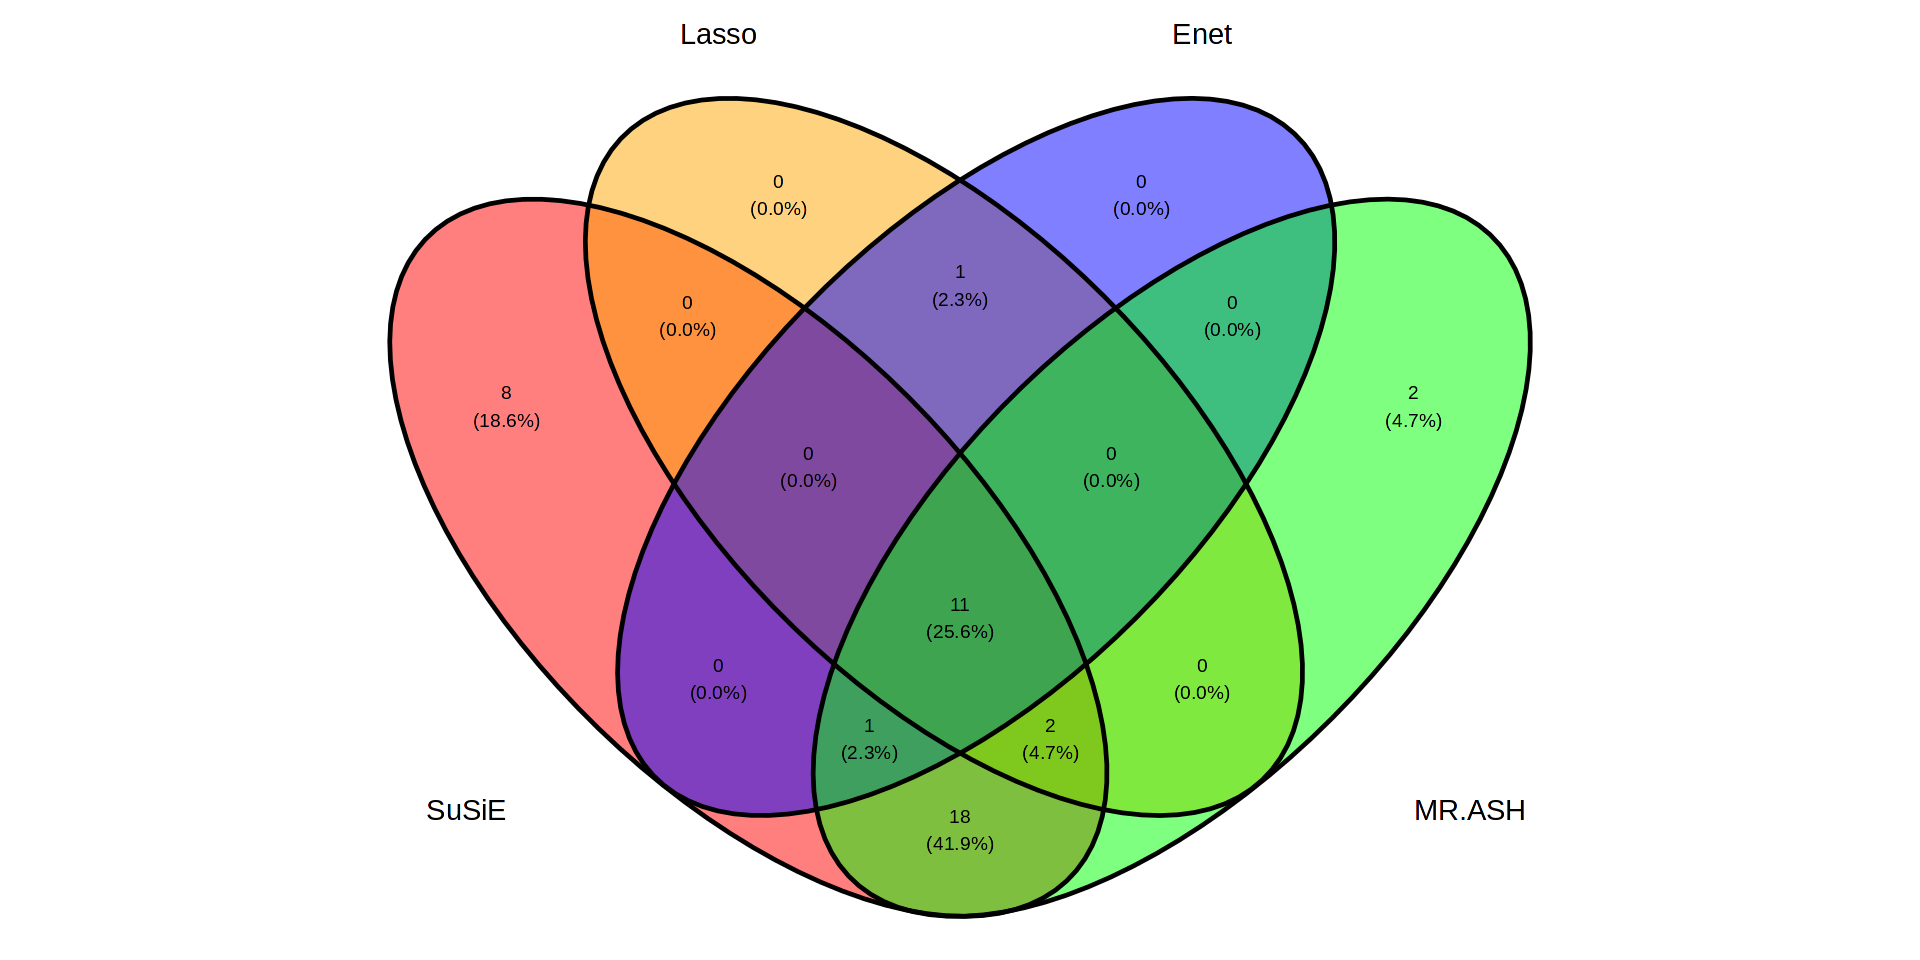

In [6]:
library(VennDiagram)
library(ggvenn)
D = list('SuSiE' = susie,'Lasso' = lasso, 'Enet' =  enet, 'MR.ASH' = mr_ash)
ggvenn(D,c("SuSiE","Lasso","Enet","MR.ASH"),show_percentage=TRUE,fill_color = c("red","orange","blue","green"))
options(repr.plot.width = 16, repr.plot.height = 8)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `chr = as.numeric(str_sub(`#chr`, 4))`.
Caused by warning:
! NAs introduced by coercion”
Warning message in geom_point(aes(color = as.factor(chr), show.legend = FALSE), :
“Ignoring unknown aesthetics: show.legend”
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“The `guide` argument in `scale_*()` cannot be `FALSE`. This was deprecated in
ggplot2 3.3.4.
ℹ Please use "none" instead.”


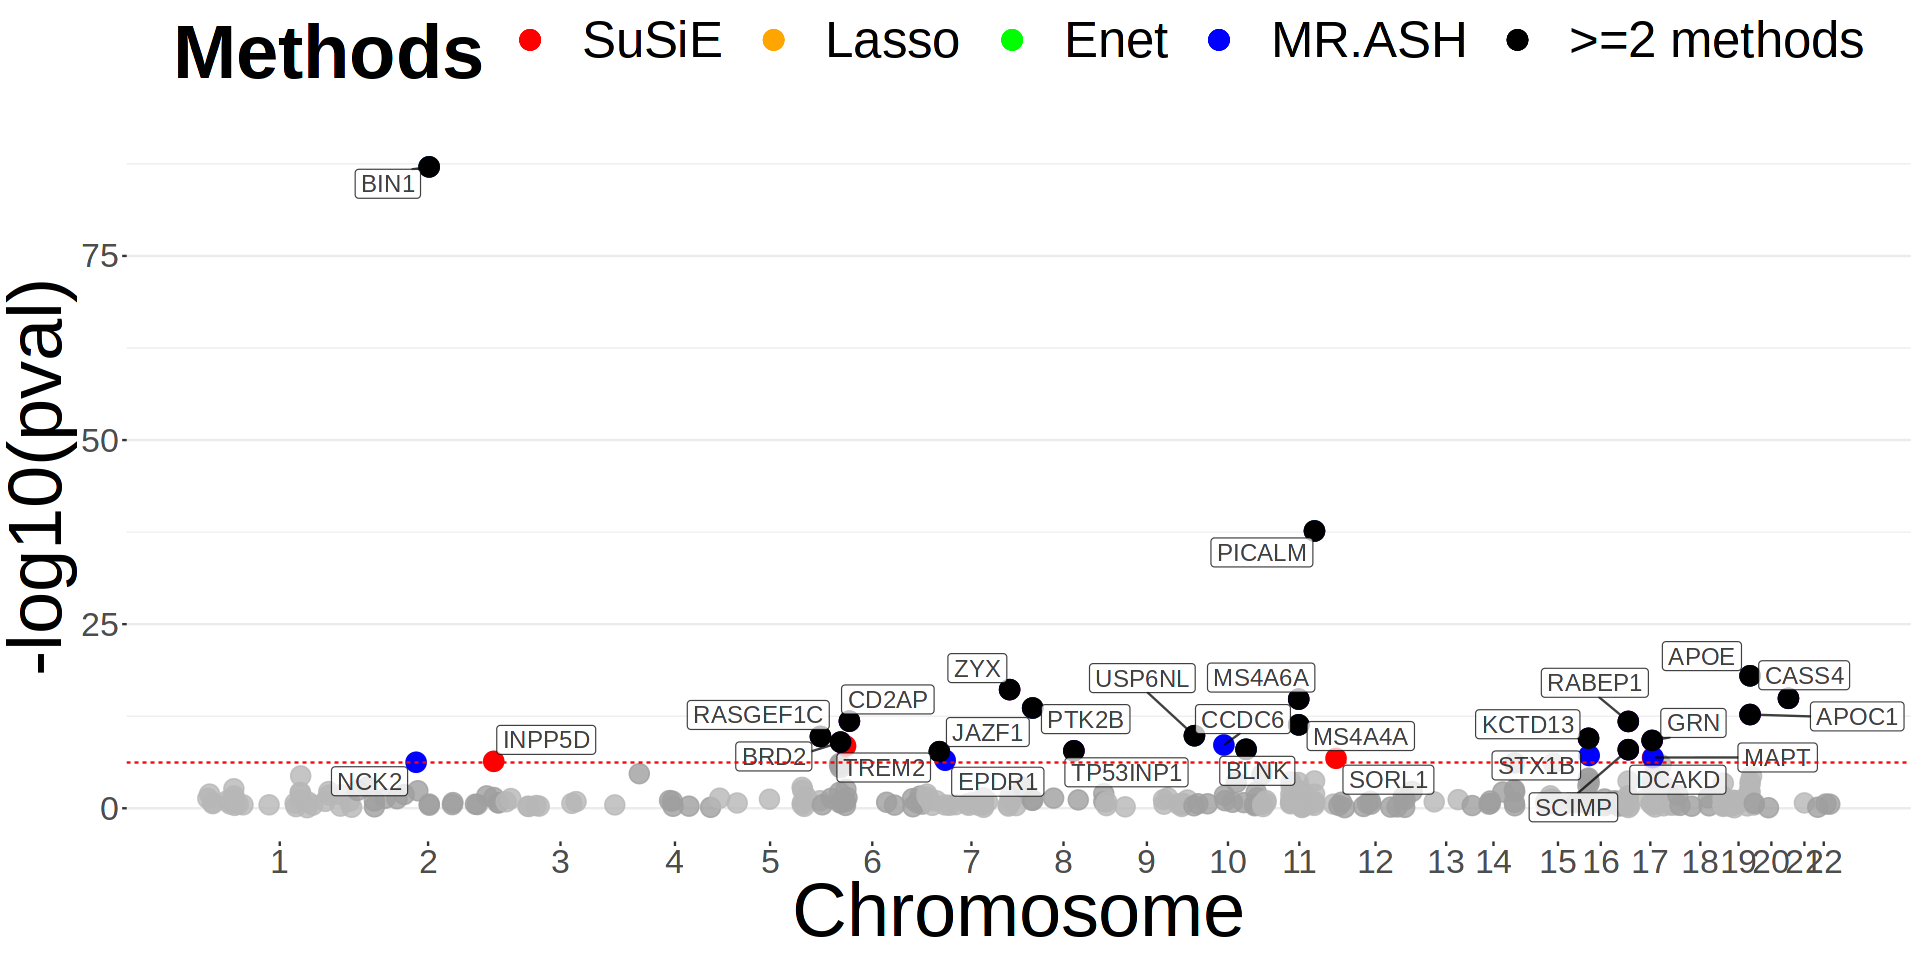

In [7]:
library(stringr)
library(ggnewscale)
library(ggrepel)
min_pval = apply(Mic_genes$gene_pq_adj[,c("susie_pval","lasso_pval","enet_pval","mr_ash_pval")],1,function(x) min(x,na.rm=TRUE))
data_all_gene = Mic_genes$gene_pq_adj%>%select(gene_name,chr,gene_id,susie_pval,lasso_pval,enet_pval,mr_ash_pval)%>%mutate(min_pval = min_pval)%>%mutate(chr=as.numeric(chr))
gene_pos = fread("~/MR_KMT_analysis/PTWAS/Mic_AD_phenotype_select.txt")%>%mutate(chr = as.numeric(str_sub(`#chr`,4)))%>%select(-`#chr`)%>%setNames(c("start_bp","end_bp","gene_name","chr"))
gene_pos_pval = merge(data_all_gene,gene_pos,by = c("gene_name","chr"))
susie_select = Mic_genes$gene_pq_adj$gene_id[Mic_genes$gene_pq_adj$susie_pval<(2.5*10^(-6)/4)]
lasso_select = Mic_genes$gene_pq_adj$gene_id[Mic_genes$gene_pq_adj$lasso_pval<(2.5*10^(-6)/4)]
enet_select = Mic_genes$gene_pq_adj$gene_id[Mic_genes$gene_pq_adj$enet_pval<(2.5*10^(-6)/4)]
ash_select = Mic_genes$gene_pq_adj$gene_id[Mic_genes$gene_pq_adj$mr_ash_pval<(2.5*10^(-6)/4)]
gene_annotate = unique(c(susie_select,lasso_select,enet_select,ash_select))
#### more than 2 methods have intersection
d1 = intersect(susie_select,lasso_select)
d2 = intersect(susie_select,enet_select)
d3 = intersect(susie_select,ash_select)
d4 = intersect(lasso_select,enet_select)
d5 = intersect(lasso_select,ash_select)
d6 = intersect(enet_select,ash_select)
d7 = intersect(intersect(susie_select,lasso_select),ash_select)
d8 = intersect(intersect(susie_select,enet_select),ash_select)
d9 = intersect(intersect(susie_select,lasso_select),enet_select)
d10 = intersect(intersect(ash_select,lasso_select),enet_select)
d11 = intersect(intersect(intersect(susie_select,lasso_select),enet_select),ash_select)
two_more = unique(c(d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11))
don <- gene_pos_pval %>% 
  #Compute chromosome size
  group_by(chr) %>% 
  summarise(chr_len=max((start_bp+end_bp)/2)) %>%  
  
  # Calculate cumulative position of each chromosome
   mutate(tot=cumsum(chr_len)-chr_len) %>%
   select(-chr_len) %>%
  # 
  # # Add this info to the initial dataset
   left_join(gene_pos_pval, ., by=c("chr"="chr")) %>%
  # 
  # # Add a cumulative position of each SNP
   arrange(chr, (start_bp+end_bp)/2) %>%
   mutate( BPcum=(start_bp+end_bp)/2+tot) %>%
   mutate( susie_highlight=ifelse(gene_id %in% susie_select, "yes", "no")) %>%
   mutate( lasso_highlight=ifelse(gene_id %in% lasso_select, "yes", "no")) %>%
   mutate( enet_highlight=ifelse(gene_id %in% enet_select, "yes", "no")) %>%
   mutate( ash_highlight=ifelse(gene_id %in% ash_select, "yes", "no")) %>%
   mutate( two_highlight = ifelse(gene_id %in% two_more, "yes", "no")) %>%
   mutate( gene_annotate = ifelse(gene_id %in% gene_annotate, "yes", "no"))  
  
axisdf = don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )
# ######TWAS-GKF
ggplot(don, aes(x=BPcum, y=-log10(min_pval))) +
  
  # Show all points
  geom_point(aes(color=as.factor(chr),show.legend=FALSE), alpha=0.8, size=5) +
  scale_color_manual(values = rep(c("#b6b6b6","#9f9f9f"), 22),guide=FALSE)+
  # custom X axis:
  scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
  scale_y_continuous(expand = c(0, 0)) +  # remove space between plot area and x axis
  ylim(0,90)+
  new_scale_color()+
  geom_point(data = subset(don,susie_highlight=="yes"),aes(color="red"),size=5)+
  geom_point(data = subset(don,lasso_highlight=="yes"),aes(color="orange"),size=5)+
  geom_point(data = subset(don,enet_highlight=="yes"),aes(color="green"),size=5)+
  geom_point(data = subset(don,ash_highlight=="yes"),aes(color="blue"),size=5)+
  geom_point(data = subset(don,two_highlight=="yes"),aes(color="black"),size=5)+
  geom_label_repel(data = subset(don,gene_annotate=="yes"),aes(label = gene_id),size=5,max.overlaps = Inf,color = "black",alpha=0.75)+
  #geom_label_repel(data = subset(don,S_annotate=="yes"),aes(label = gene_name),size=12,max.overlaps = Inf,box.padding = 2.5,color = "red",alpha=0.75)+
  scale_color_manual(values = c("red","orange","green","blue","black"),breaks = c("red","orange","green","blue","black"),name = "Methods",labels = c("SuSiE","Lasso","Enet","MR.ASH",">=2 methods")) +
  xlab("Chromosome")+
  ylab("-log10(pval)")+
  geom_hline(yintercept = -log10(2.5*10^(-6)/4), linetype = "dashed", color = "red")+
  theme_bw() +
  theme( 
    #legend.position="none",
    plot.title = element_text(size = 45),
    legend.title = element_text(face = "bold",size = 45),
    legend.text = element_text(size = 30),
    axis.text = element_text(size=20),
    axis.title = element_text(size = 45),
    legend.position = "top",
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank()
  )
options(repr.plot.width = 25, repr.plot.height = 8)

#### Mic MR results
* intersection: there are eleven causal genes obtained by four methods, **BIN1**, **RASGEF1C**, **JAZF1**, **PTK2B**, **TP53INP1**, **USP6NL**, **BLNK**, **MS4A4A**, **PICALM**, **RIN3**, **APOE**
* union of four methods (25 genes): **BIN1**, **INPP5D**, **RHOH**, **RASGEF1C**, **CD2AP**, **JAZF1**, **EPDR1**, **ZYX**, **PTK2B**, **TP53INP1**, **USP6NL**, **CCDC6**, **BLNK**, **PLEKHA1**, **MS4A6A**, **MS4A4A**, **PICALM**, **RIN3**, **LACTB**, **RABEP1**, **APOE**, **APOC1**, **CASS4**, **NCK2**, **HLA-C**

In [9]:
Mic_mr = readRDS("~/MR_KMT_analysis/PTWAS/Mic/mr_output.rds")
susie_mr = Mic_mr$susie_adj$gene_id[Mic_mr$susie_adj$meta_qval<=0.05]
lasso_mr = Mic_mr$lasso_adj$gene_id[Mic_mr$lasso_adj$meta_qval<=0.05]
enet_mr = Mic_mr$enet_adj$gene_id[Mic_mr$enet_adj$meta_qval<=0.05]
ash_mr = Mic_mr$mr_ash_adj$gene_id[Mic_mr$mr_ash_adj$meta_qval<=0.05]
intersect(intersect(intersect(susie_mr,lasso_mr),enet_mr),ash_mr)
Mic_mr_merge = unique(c(susie_mr,lasso_mr,enet_mr,ash_mr))
Mic_mr_merge
Mic_mr$susie_adj

[1] "BIN1"     "RASGEF1C" "JAZF1"    "PTK2B"    "TP53INP1" "USP6NL"  
 [7] "BLNK"     "MS4A4A"   "PICALM"   "RIN3"     "APOE"

[1] "BIN1"     "INPP5D"   "RHOH"     "RASGEF1C" "CD2AP"    "JAZF1"   
 [7] "EPDR1"    "ZYX"      "PTK2B"    "TP53INP1" "USP6NL"   "CCDC6"   
[13] "BLNK"     "PLEKHA1"  "MS4A6A"   "MS4A4A"   "PICALM"   "RIN3"    
[19] "LACTB"    "RABEP1"   "APOE"     "APOC1"    "CASS4"    "NCK2"    
[25] "HLA-C"

X_ID,num_CS,num_IV,cpip,gene_id,meta_eff,se_meta_eff,meta_pval,meta_qval,Q,Q_pval,I2
<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000136717,1,1,0.996,BIN1,0.018,0.002,0.000,0.000,0.000,1.000,0.000
ENSG00000168918,1,2,0.596,INPP5D,0.009,0.002,0.000,0.000,0.000,1.000,0.000
ENSG00000168421,1,1,0.994,RHOH,-0.008,0.002,0.000,0.000,0.000,1.000,0.000
ENSG00000146090,4,28,0.899,RASGEF1C,-0.004,0.001,0.000,0.000,16.936,0.001,0.823
ENSG00000198087,1,53,0.878,CD2AP,0.009,0.002,0.000,0.000,0.000,1.000,0.000
ENSG00000153814,2,7,0.801,JAZF1,-0.002,0.000,0.000,0.000,0.009,0.924,0.000
ENSG00000086289,1,27,0.879,EPDR1,-0.007,0.002,0.000,0.000,0.000,1.000,0.000
ENSG00000159840,2,6,0.956,ZYX,-0.008,0.002,0.000,0.000,8.833,0.003,0.887
ENSG00000120899,1,5,0.999,PTK2B,0.005,0.001,0.000,0.000,0.000,1.000,0.000


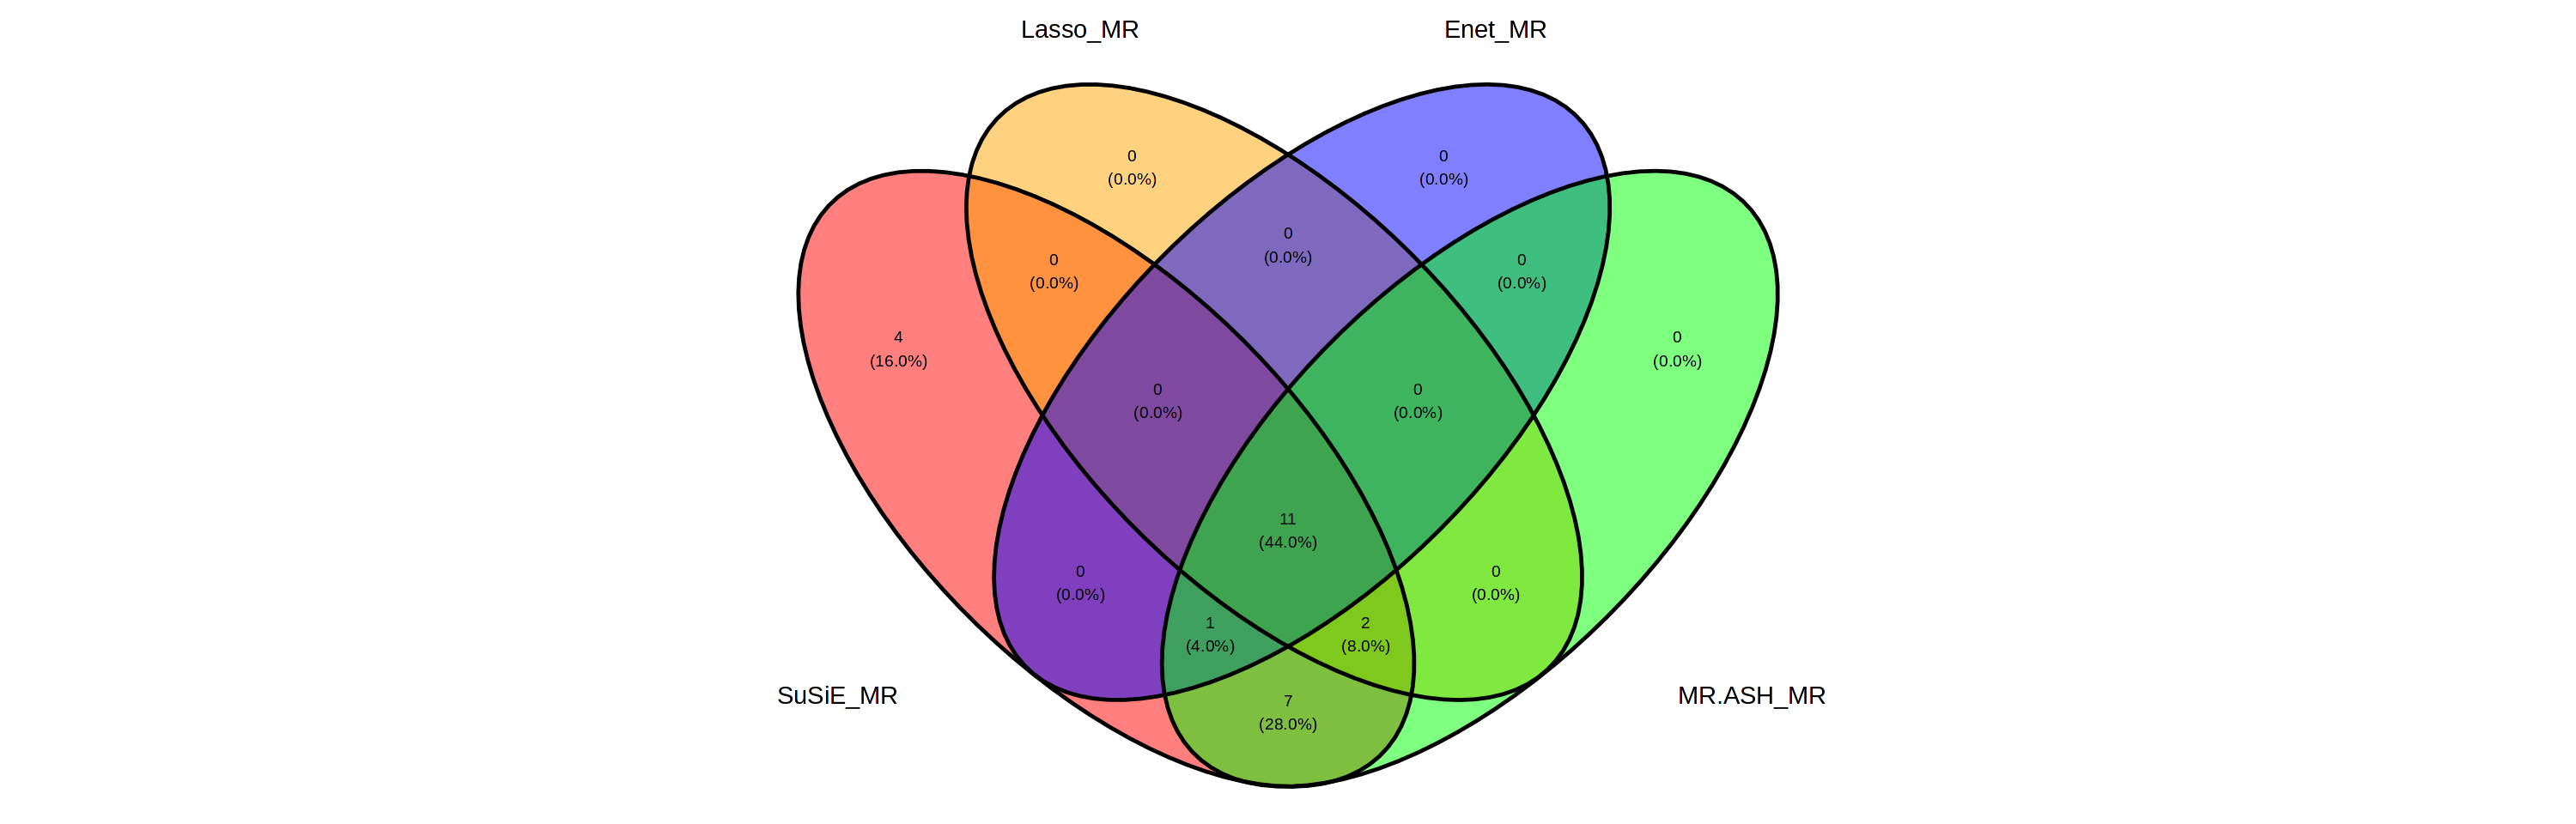

In [10]:
library(VennDiagram)
library(ggvenn)
D = list('SuSiE_MR' = susie_mr,'Lasso_MR' = lasso_mr, 'Enet_MR' =  enet_mr, 'MR.ASH_MR' = ash_mr)
ggvenn(D,c("SuSiE_MR","Lasso_MR","Enet_MR","MR.ASH_MR"),show_percentage=TRUE,fill_color = c("red","orange","blue","green"))
options(repr.plot.width = 16, repr.plot.height = 8)